In [1]:
import csv
import numpy as np

In [2]:
def get_characters_and_floor_bin(match_str):
    # This is the separator between the character codes and the match datetime: 0x95 0xB2
    # However sometimes it can appear multiple times because some other data is coincidentally set to the same values
    # Those cases are very rare however approx 3 in 80000
    index = match_str.index(b'\x95\xb2')
    raw_bytes = match_str[index-3:index]
    char_codes = [int(x) for x in raw_bytes]
    if max(char_codes[1:]) > 16:
        raise Exception('TOO MANY MATCHES',match_str.count(b'\x95\xb2'),match_str)
    return char_codes

def get_winner_bin(match_str):
    raw_bytes = int(match_str[-1])
    return raw_bytes

def get_date_bin(match_str):
    return match_str[:14].decode()

def get_match_data_bin(match_str):
    data = get_characters_and_floor_bin(match_str)
    data.append(get_winner_bin(match_str))
    data.insert(0,get_date_bin(match_str))
    
    return data

In [3]:
with open('outputs/replaysRAW.txt', "rb") as f:
    data = f.read()
    # When writing the files from the modified totsugeki.exe we use a sequence of 8 0xF2 as a delimiter between calls
    bin_matches = data.split(b'\xf2\xf2\xf2\xf2\xf2\xf2\xf2\xf2')


match_list = []
match_list_raw = []
match_list_bin = []
# page here denotes a set of games when scrolling through the replays list
for page in bin_matches:
    match_str_list = page.split(b'\xb32021\x2d')
    # The first and last match strings are not formatted the same as the rest
    # I think they might contain metadata about the request
    # TODO: Isolate and investigate what exactly that is
    for match_str in match_str_list[1:-1]:
        try:
            match_list_bin.append(match_str)
            match_list_raw.append(np.array([x for x in match_str]))
            match_list.append(get_match_data_bin(match_str))
        except Exception as e:
            pass
#             print(e, [x for x in match_str])

In [4]:
with open('GGST_Replays.csv', 'w') as f:
    fields  = ['date','floor','p1CharCode','p2CharCode', 'winner']
    writer = csv.writer(f)
    writer.writerow(fields)
    writer.writerows(match_list)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
LOCAL_TIMEZONE = datetime.datetime.now().astimezone().tzinfo

In [6]:
df =pd.read_csv('GGST_Replays.csv')

In [7]:
df.head()

,date,floor,p1CharCode,p2CharCode,winner
0,09-24 20:12:25,10,11,11,2
1,09-24 20:10:38,9,11,11,1
2,09-24 20:02:57,9,11,11,1
3,09-24 20:01:11,9,11,11,1
4,09-24 19:59:41,10,11,11,2


In [8]:
df.shape

(287534, 5)

In [9]:
print('data was collected between', df['date'].min(), 'and', df['date'].max()) 

data was collected between 09-24 02:10:23 and 09-26 19:20:07


In [10]:
def convert_to_datetime(api_date):
    return np.datetime64('2021-'+api_date)

# TODO:  fix this
def convert_to_hours_and_mins(api_date):
    return np.datetime64(api_date[6:].replace(':','-'))

# convert_to_hours_and_mins(df['date'][0])
df['date'] = df['date'].apply(convert_to_datetime)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


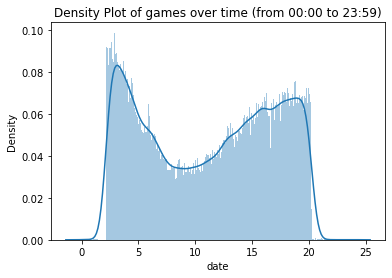

In [11]:
# NOTE: these times are from the timezone where the data was collected
# in my case this is UTC+2
time_of_day = pd.DatetimeIndex(df['date']).hour + pd.DatetimeIndex(df['date']).minute/60
plt.title('Density Plot of games over time (from 00:00 to 23:59)')
plt.show(sns.distplot(time_of_day , bins=24*30))

In [12]:
readable_character_names = ['sol', 'ky', 'may', 'axl', 'chipp', 'potemkin', 'faust', 'millia', 'zato', 'ramlethal', 'leo', 'nagoriyuki', 'giovanna', 'anji', 'i-no', 'goldlewis', 'jack-o']
chars, counts = np.unique(df[['p1CharCode','p2CharCode']].to_numpy(), return_counts=True)

In [37]:
floors_to_examine = [1,2,3,4,5]
n = len(readable_character_names)
wins = np.zeros(n)
losses = np.zeros(n)
matchup_wins = np.zeros((n,n))
matchup_losses = np.zeros((n,n))
num_games_at_floor = np.zeros(11)
for index, row in df.iterrows():
    if row['floor'] in floors_to_examine:
        winner = row['p1CharCode'] if row['winner'] == 1 else row['p2CharCode']
        loser  = row['p1CharCode'] if row['winner'] == 2 else row['p2CharCode']
        wins[winner] += 1
        losses[loser] += 1
        matchup_wins[winner][loser] += 1
        matchup_losses[loser][winner] += 1
    if row['floor'] == 99:
        num_games_at_floor[10] += 1
    else:
        num_games_at_floor[row['floor']] += 1


In [38]:
total_games = (wins+losses)
winrate = wins/total_games

matchup_totals = matchup_wins+matchup_losses
matchup_table = matchup_wins/matchup_totals

<ipython-input-38-9c2e6e1c6738>:5: RuntimeWarning: invalid value encountered in true_divide
  matchup_table = matchup_wins/matchup_totals


In [39]:
sorted(list(zip(readable_character_names, np.around(winrate,4), total_games)),key=lambda x : x[1])

[('anji', 0.2829, 661.0),
 ('jack-o', 0.3664, 655.0),
 ('leo', 0.4198, 655.0),
 ('goldlewis', 0.4266, 368.0),
 ('ramlethal', 0.4526, 2459.0),
 ('giovanna', 0.4562, 2501.0),
 ('millia', 0.4643, 1288.0),
 ('zato', 0.4938, 808.0),
 ('chipp', 0.4973, 1108.0),
 ('faust', 0.5293, 939.0),
 ('i-no', 0.5429, 641.0),
 ('nagoriyuki', 0.5496, 1290.0),
 ('axl', 0.5531, 687.0),
 ('sol', 0.5617, 956.0),
 ('ky', 0.6058, 1621.0),
 ('potemkin', 0.6357, 645.0),
 ('may', 0.6383, 846.0)]

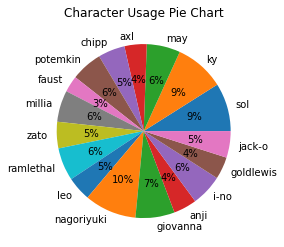

In [34]:
plt.title('Character Usage Pie Chart')
plt.show(plt.pie(total_games, labels=readable_character_names, autopct=lambda x : str(int(np.round(x)))+'%'))

[0.00000e+00 5.00000e+00 5.80000e+01 1.50000e+02 3.62600e+03 5.22500e+03
 1.62510e+04 2.12100e+04 3.92090e+04 4.44760e+04 1.57324e+05]


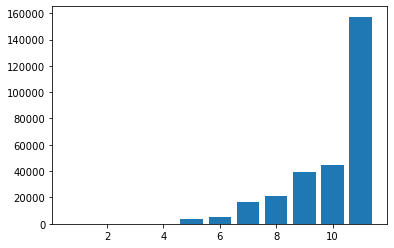

In [35]:
# x , y = np.unique(df.floor, return_counts=True)
x , y = list(range(1,12)), num_games_at_floor
print(num_games_at_floor)
plt.show(plt.bar(x, y))

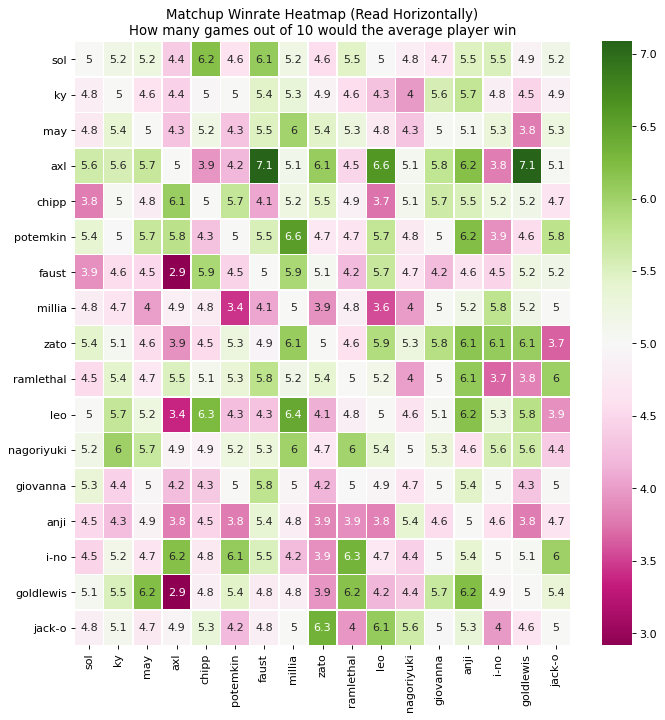

In [36]:
from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=80)

plt.title('Matchup Winrate Heatmap (Read Horizontally)\nHow many games out of 10 would the average player win')
ratios = (matchup_table)*10
plt.show(sns.heatmap(ratios, linewidth=0.5,xticklabels = readable_character_names, yticklabels = readable_character_names, cmap="PiYG", annot=ratios))


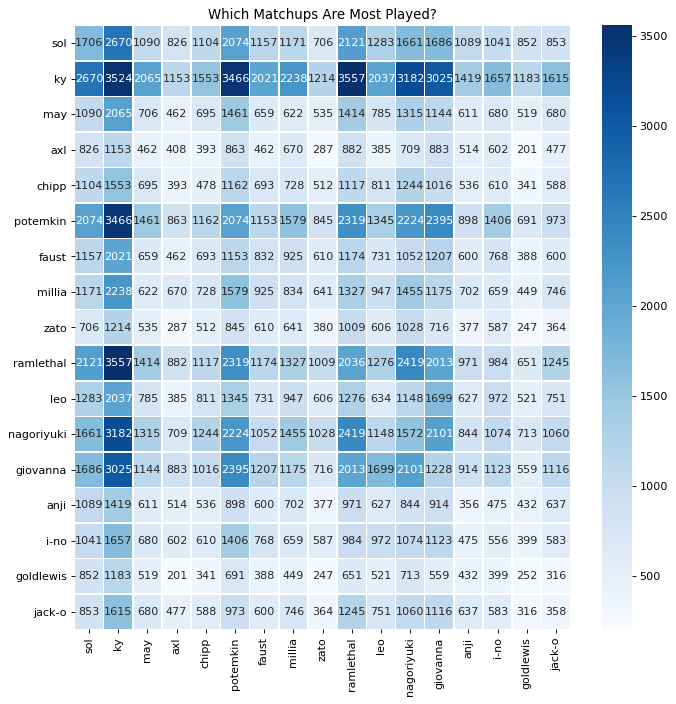

In [25]:
figure(figsize=(10, 10), dpi=80)
annotations = matchup_totals
plt.title('Which Matchups Are Most Played?')
plt.show(sns.heatmap(matchup_totals, linewidth=0.5,xticklabels = readable_character_names, yticklabels = readable_character_names, cmap="Blues",annot=True, fmt='g'))

In [26]:
least_played_matchup = np.unravel_index(np.argmin(matchup_totals, axis=None), matchup_totals.shape)
least_played_matchup_human_readable = [readable_character_names[x] for x in least_played_matchup]
least_played_matchup_value = np.min(matchup_totals)
print('least played matchup is:', least_played_matchup_human_readable, 'with ',least_played_matchup_value, 'games played in total')

least played matchup is: ['axl', 'goldlewis'] with  201.0 games played in total


In [27]:
most_played_matchup = np.unravel_index(np.argmax(matchup_totals, axis=None), matchup_totals.shape)
most_played_matchup_human_readable = [readable_character_names[x] for x in most_played_matchup]
most_played_matchup_value = np.max(matchup_totals)
print('most played matchup is:', most_played_matchup_human_readable, 'with ',most_played_matchup_value, 'games played in total')

most played matchup is: ['ky', 'ramlethal'] with  3557.0 games played in total


In [28]:
play_percentage = total_games/sum(total_games) 
# to find P(A and B) simply take P(A) * P(B)

num_chars = len(play_percentage)
predicted_matchup_rates = np.zeros((num_chars,num_chars))
for i in range(num_chars):
    for k in range(num_chars):
        predicted_matchup_rates[i][k] = play_percentage[i] * play_percentage[k]

predicted_matchup_values = np.around(predicted_matchup_rates*sum(total_games)) 

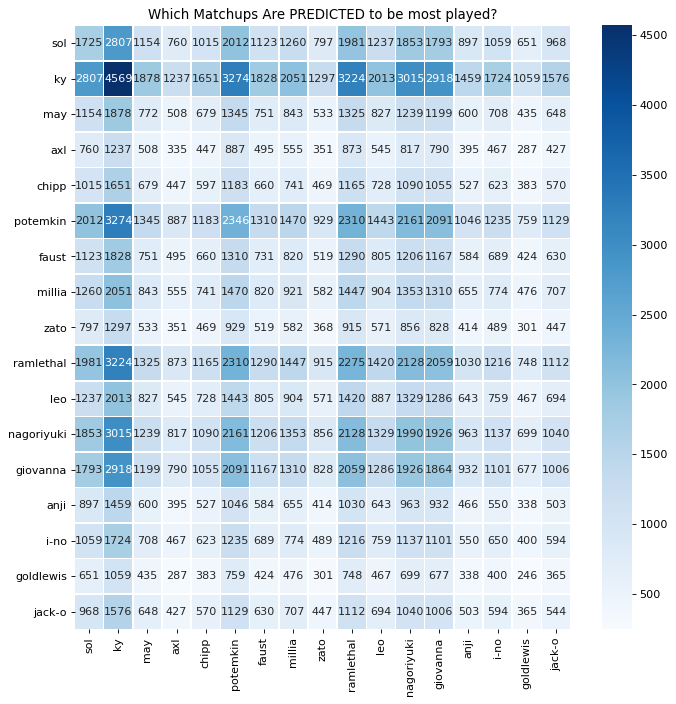

In [29]:
figure(figsize=(10, 10), dpi=80)
plt.title('Which Matchups Are PREDICTED to be most played?')
plt.show(sns.heatmap(predicted_matchup_values, linewidth=0.5,xticklabels = readable_character_names, yticklabels = readable_character_names, cmap="Blues",annot=True, fmt='g'))

0.24308416715715125 -0.5195530726256983


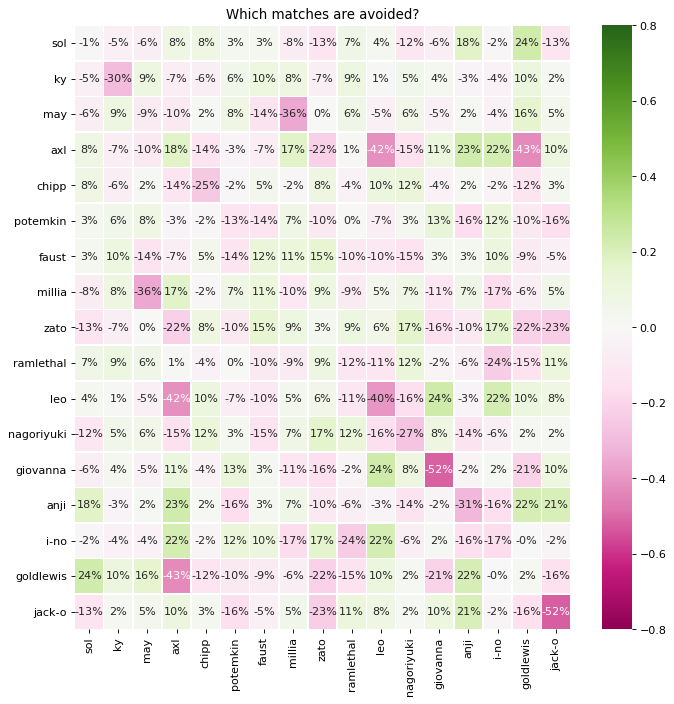

In [30]:
figure(figsize=(10, 10), dpi=80)
plt.title('Which matches are avoided?')
matchup_prediction_error = (matchup_totals - predicted_matchup_values)/matchup_totals
print(np.max(matchup_prediction_error), np.min(matchup_prediction_error))
plt.show(sns.heatmap(matchup_prediction_error, linewidth=0.5,xticklabels = readable_character_names, yticklabels = readable_character_names, cmap="PiYG",annot=True, fmt='.0%',vmin=-0.8,vmax=0.8))